In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import os
from dotenv import load_dotenv
from financial.momentum.utilities import find_dotenv
import financial.data as fd
from financial.momentum.experiment.modelExperiment import ModelExperimentFactory
from financial.io.file.cache import FileCache
import pandas as pd

In [15]:
load_dotenv(dotenv_path=find_dotenv())

cache = os.environ["CACHE"]
model = os.environ["MODEL"]
print(model)
print(os.environ["DATA"])
datastore = fd.CachedDataStore(path=os.environ["DATA"], cache=FileCache(cache_path=cache+"/"))
print(datastore)                

/home/manidmt/Universidad/TFG/OTRI/models/scikit-learn
/home/manidmt/Universidad/TFG/OTRI/data
CachedDataStore with 946 data sources [cache stats: {'size': 0, 'hit': 0, 'miss': 0, 'write': 0, 'read': 0, 'update': 0}]


In [16]:
import financial.model as fm
import financial.lab.models as labmodels
import sklearn.linear_model

class LinearScikitLearnModelFactory (labmodels.ModelFactory):
    '''
    Linear regression Scikit-Learn model factory
    '''
        
    def create_model_from_descriptors(self, 
                                      model_id: str, 
                                      hyperparameters: dict, 
                                      input_descriptor: fd.DataDescriptor, 
                                      output_descriptor: fd.DataDescriptor) -> fm.Model:
        model = sklearn.linear_model.LinearRegression()
        return fm.ScikitLearnModel(model_id, input_descriptor, output_descriptor, model, hyperparameters)
        

factory = LinearScikitLearnModelFactory()

In [17]:
start_date = "1990-01-01"
end_date = "2023-12-31"
ticker = "^GSPC"

config = {
    "mode": "global",
    "datastore": datastore,
    "ticker": ticker,
    "model_factory": factory,
    "name": "global_first_experiment",
    "start_year": start_date,
    "end_year": end_date
}

In [18]:
import pickle

path_train = os.path.join(cache, f"{config["name"]}.results.{config["ticker"]}.train.pickle")
with open(path_train, 'rb') as file:
    predictions_train = pickle.load(file)
print(predictions_train)

path_test = os.path.join(cache, f"{config["name"]}.results.{config["ticker"]}.test.pickle")
with open(path_test, 'rb') as file:
    predictions_test = pickle.load(file)
print(predictions_test)

global_first_experiment.^GSPC.train
global_first_experiment.^GSPC.test


In [19]:
from financial.lab.experiment import ExperimentBatch

experimentBatch = ExperimentBatch("TestLinearTest")
experimentBatch.from_file(path_train)

print(experimentBatch)
#experimentBatch['train'][ticker]

TestLinearTest experiments=0 n=0


In [20]:
experiment_linear = ModelExperimentFactory.create_experiment(config)
experiment_linear.run()
print(experiment_linear.predictions)

1990-05-10   -0.002445
1990-05-11    0.000419
1990-05-14    0.000412
1990-05-15   -0.002300
1990-05-16   -0.001051
                ...   
2023-12-22   -0.003897
2023-12-26   -0.002925
2023-12-27    0.000292
2023-12-28    0.000937
2023-12-29    0.000158
Length: 8475, dtype: float64


In [21]:
absolute_predictions_linear = experiment_linear.reconstruct_absolute_predictions_from_relative()

In [22]:
from financial.momentum.models.randomForest import RandomForestModelFactory

factory = RandomForestModelFactory()
config = {
    "mode": "global",
    "datastore": datastore,
    "ticker": ticker,
    "model_factory": factory,
    "name": "global_forest_first_experiment",
    "start_year": start_date,
    "end_year": end_date
}


In [25]:
experiment_forest = ModelExperimentFactory.create_experiment(config)
experiment_forest.run()

In [26]:
import pickle
path = os.path.join(model, f"{config["name"]}.pickle")
with open(path, 'rb') as file:
    predictions = pickle.load(file)
print(experiment_forest.predictions)

1990-05-10   -0.031734
1990-05-11   -0.016927
1990-05-14   -0.025651
1990-05-15   -0.024577
1990-05-16   -0.023041
                ...   
2023-12-22   -0.035808
2023-12-26   -0.031003
2023-12-27   -0.033587
2023-12-28   -0.031352
2023-12-29   -0.033377
Length: 8475, dtype: float64


In [27]:
data = datastore.get_data(ticker, start_date, end_date)

In [29]:
'''
stdev = experiment_forest.target[0].stdev
mean = experiment_forest.target[0].mean
deconstructed_predictions = (experiment_forest.predictions /stdev) - mean


def reconstruct_relative(data: pd.Series, model_output: pd.Series) -> pd.Series:
    #print(model_output[:-lookahead])
    reconstructed_change = - (mean+stdev*model_output) # Sign reversal @ shift(-lookahead)
    #print("reconstructed change")
    #print(reconstructed_change[:-lookahead]) 
    # change = (final-inicial)/final => change*final = final-inicial => final = inicial/(1-change)
    reconstructed_final = data / (1-reconstructed_change)
    #print("reconstructed final")
    #print(reconstructed_final[:-lookahead].dropna()) 
    return reconstructed_final.shift(20).dropna()


print(reconstruct_relative(data, deconstructed_predictions))
'''

'\nstdev = experiment_forest.target[0].stdev\nmean = experiment_forest.target[0].mean\ndeconstructed_predictions = (experiment_forest.predictions /stdev) - mean\n\n\ndef reconstruct_relative(data: pd.Series, model_output: pd.Series) -> pd.Series:\n    #print(model_output[:-lookahead])\n    reconstructed_change = - (mean+stdev*model_output) # Sign reversal @ shift(-lookahead)\n    #print("reconstructed change")\n    #print(reconstructed_change[:-lookahead]) \n    # change = (final-inicial)/final => change*final = final-inicial => final = inicial/(1-change)\n    reconstructed_final = data / (1-reconstructed_change)\n    #print("reconstructed final")\n    #print(reconstructed_final[:-lookahead].dropna()) \n    return reconstructed_final.shift(20).dropna()\n\n\nprint(reconstruct_relative(data, deconstructed_predictions))\n'

In [30]:
print(data)

1990-01-02     359.690002
1990-01-03     358.760010
1990-01-04     355.670013
1990-01-05     352.200012
1990-01-08     353.790009
                 ...     
2023-12-22    4754.629883
2023-12-26    4774.750000
2023-12-27    4781.580078
2023-12-28    4783.350098
2023-12-29    4769.830078
Name: ^GSPC, Length: 8565, dtype: float64


In [33]:
absolute_predictions_forest = experiment_forest.reconstruct_absolute_predictions_from_relative()
print(absolute_predictions_forest)

1990-05-10     355.088534
1990-05-11     358.060792
1990-05-14     364.089385
1990-05-15     363.206478
1990-05-16     362.348766
                 ...     
2023-12-22    4931.207223
2023-12-26    4927.519921
2023-12-27    4947.759068
2023-12-28    4938.171754
2023-12-29    4934.527785
Length: 8475, dtype: float64


In [34]:
from financial.momentum.models.SVR import SVRModelFactory

factory = SVRModelFactory()
config = {
    "mode": "global",
    "datastore": datastore,
    "ticker": ticker,
    "model_factory": factory,
    "name": "global_svr_first_experiment",
    "start_year": start_date,
    "end_year": end_date
}

In [35]:
experiment_svr = ModelExperimentFactory.create_experiment(config)
experiment_svr.run()
print(experiment_svr.predictions)

1990-05-10   -0.009438
1990-05-11   -0.005965
1990-05-14   -0.009168
1990-05-15   -0.010943
1990-05-16   -0.002511
                ...   
2023-12-22    0.007597
2023-12-26    0.010535
2023-12-27    0.017839
2023-12-28    0.022443
2023-12-29    0.028124
Length: 8475, dtype: float64


In [36]:
absolute_predictions_svr = experiment_svr.reconstruct_absolute_predictions_from_relative()
print(absolute_predictions_svr)

1990-05-10     347.095751
1990-05-11     354.112176
1990-05-14     358.032539
1990-05-15     358.199769
1990-05-16     354.891035
                 ...     
2023-12-22    4718.780100
2023-12-26    4724.973039
2023-12-27    4697.777502
2023-12-28    4678.352600
2023-12-29    4639.352710
Length: 8475, dtype: float64


In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl

mpl.rc('figure', figsize=(16, 9))
mpl.__version__
style.use('ggplot')
def plot_series(series: list[pd.Series], start_date: str=None, end_date: str=None):
    for i, serie in enumerate(series):
            linewidth = 1.0  # Grosor de línea predeterminado
            if i == 0:  # Si es la primera serie en la lista (índice 0)
                linewidth = 3.0  # Grosor de línea mayor
            serie[start_date:end_date].plot(linewidth=linewidth)

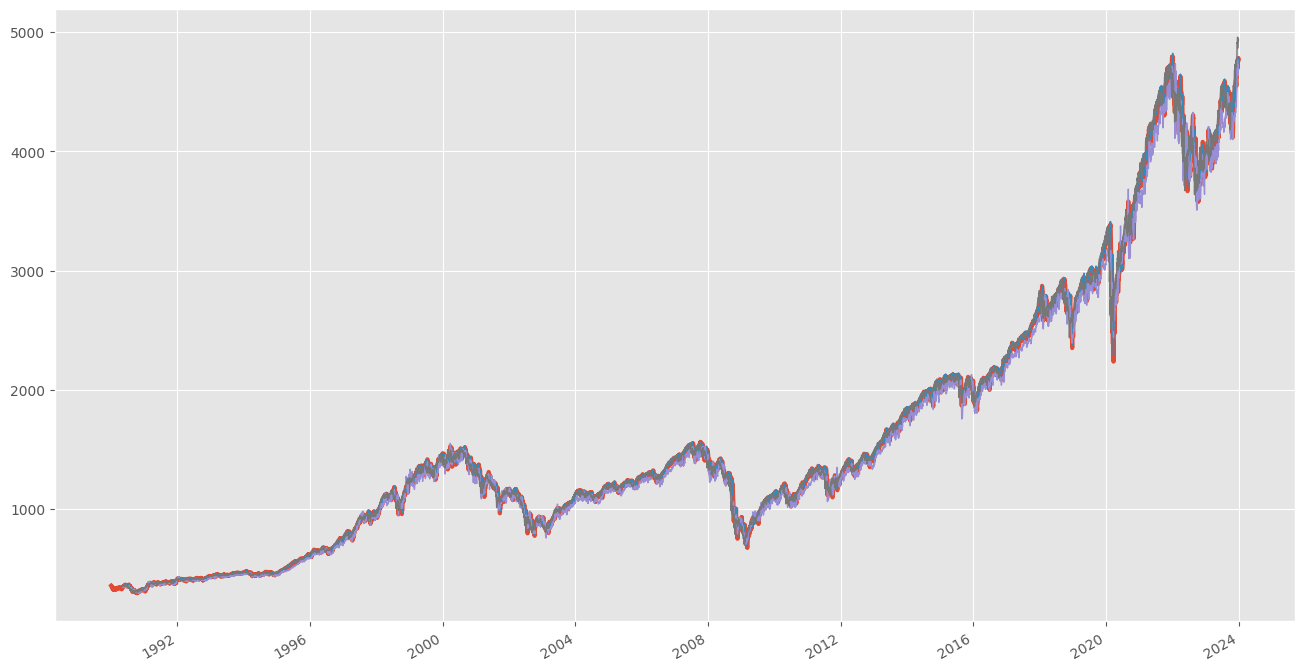

In [38]:
plot_series([data, absolute_predictions_linear, absolute_predictions_svr, absolute_predictions_forest])

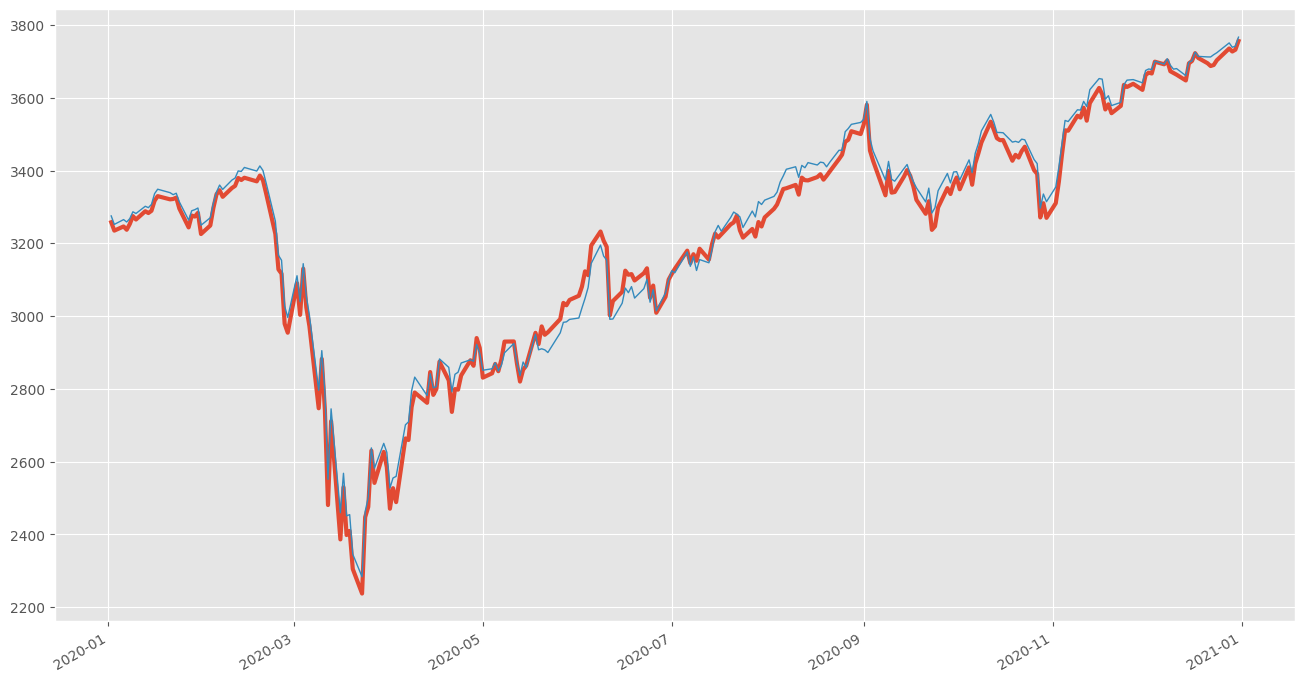

In [39]:
plot_series([data, absolute_predictions_linear], "2020-01-01", "2021-01-01")

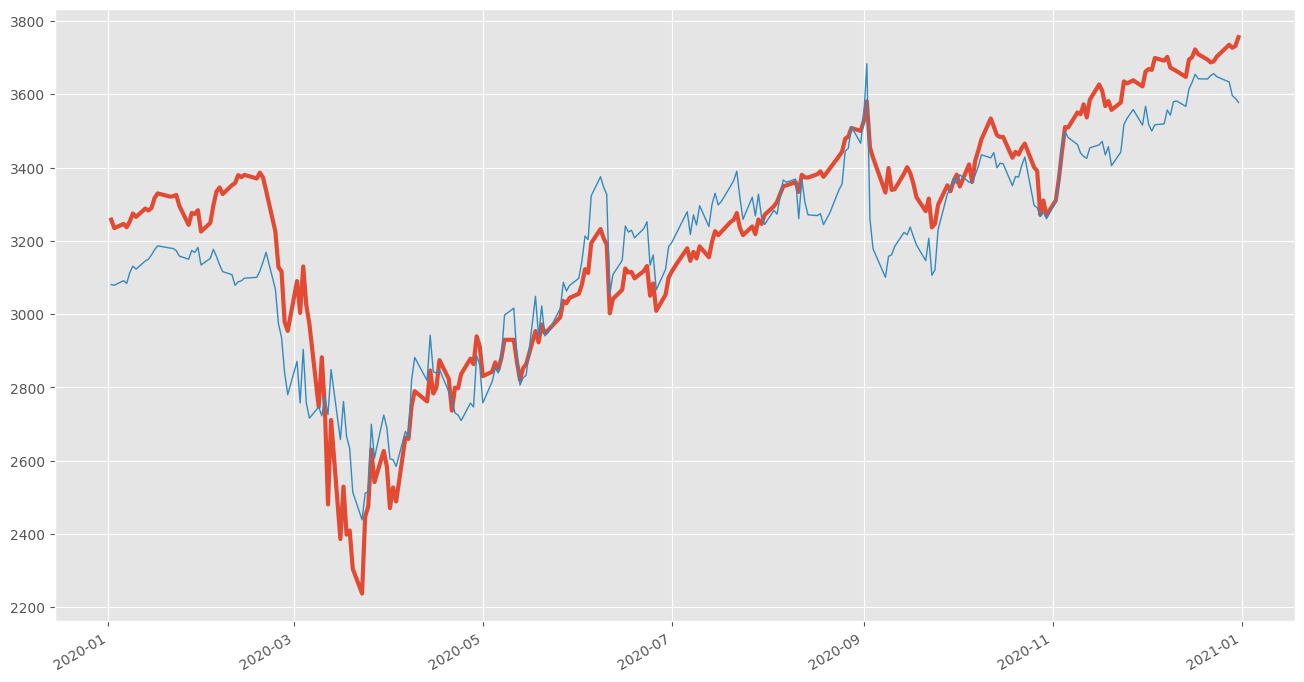

In [41]:
plot_series([data, absolute_predictions_svr], "2020-01-01", "2021-01-01")

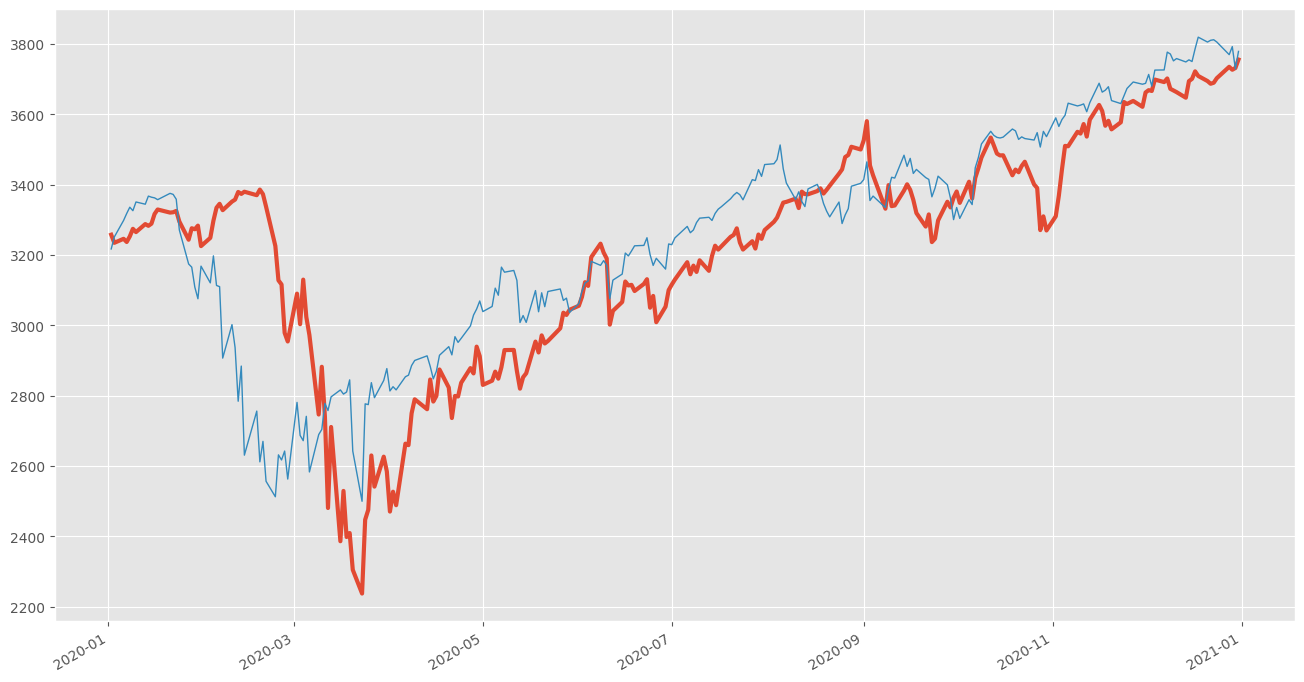

In [42]:
plot_series([data, absolute_predictions_forest], "2020-01-01", "2021-01-01")

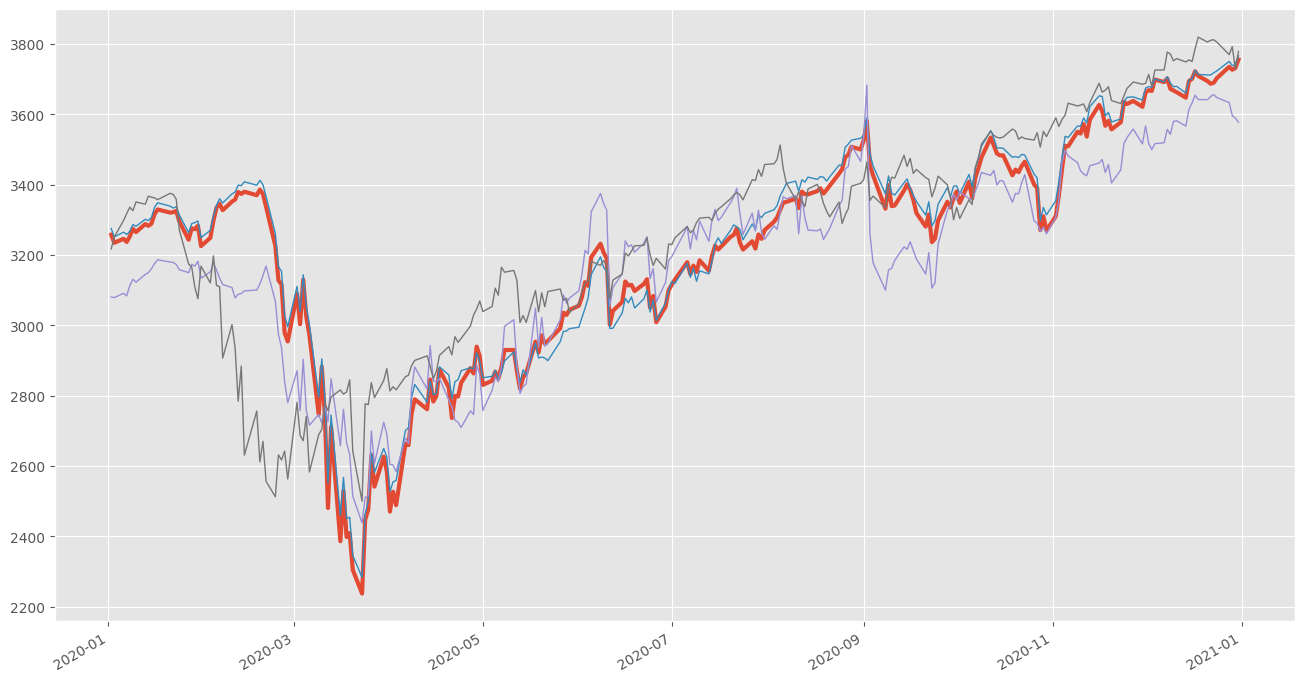

In [43]:
plot_series([data, absolute_predictions_linear, absolute_predictions_svr, absolute_predictions_forest], "2020-01-01", "2021-01-01")

In [46]:
print(experiment_svr.predictions.size)
print(absolute_predictions_svr.size)
print(data.size)
target = data[90:]
print(target.size)
from financial.lab.experiment import Experiment
from sklearn.metrics import r2_score

8475
8475
8565
8475


In [47]:
metrics_linear = Experiment(experiment_linear.name, absolute_predictions_linear, target)
r2 = r2_score(target, absolute_predictions_linear)

print("GLOBAL:")
print(f"n={metrics_linear.samples()} MSE={metrics_linear.MSE():.4f} RMSE={metrics_linear.RMSE():.4f} MAE={metrics_linear.MAE():.4f} MAPE={metrics_linear.MAPE():.4f} R² = {r2:.4f}")

print("TRAIN: ")
results = experiment_linear.train
print(f"n={results.samples()} MSE={results.MSE():.4f} RMSE={results.RMSE():.4f} MAE={results.MAE():.4f} MAPE={results.MAPE():.4f}")

print("TEST: ")
results = experiment_linear.test
print(f"n={results.samples()} MSE={results.MSE():.4f} RMSE={results.RMSE():.4f} MAE={results.MAE():.4f} MAPE={results.MAPE():.4f}")

GLOBAL:
n=8475 MSE=174.0875 RMSE=13.1942 MAE=9.4427 MAPE=0.0059 R² = 0.9999
TRAIN: 
n=62696 MSE=0.0020 RMSE=0.0447 MAE=0.0316 MAPE=1.5804
TEST: 
n=13579 MSE=0.0028 RMSE=0.0525 MAE=0.0370 MAPE=2.2418


In [48]:
metrics_svr = Experiment(experiment_svr.name, absolute_predictions_svr, target)
r2 = r2_score(target, absolute_predictions_svr)

print("GLOBAL:")
print(f"n={metrics_svr.samples()} MSE={metrics_svr.MSE():.4f} RMSE={metrics_svr.RMSE():.4f} MAE={metrics_svr.MAE():.4f} MAPE={metrics_svr.MAPE():.4f} R² = {r2:.4f}")

print("TRAIN: ")
results = experiment_svr.train
print(f"n={results.samples()} MSE={results.MSE():.4f} RMSE={results.RMSE():.4f} MAE={results.MAE():.4f} MAPE={results.MAPE():.4f}")

print("TEST: ")
results = experiment_svr.test
print(f"n={results.samples()} MSE={results.MSE():.4f} RMSE={results.RMSE():.4f} MAE={results.MAE():.4f} MAPE={results.MAPE():.4f}")

GLOBAL:
n=8475 MSE=4334.1181 RMSE=65.8340 MAE=46.0777 MAPE=0.0287 R² = 0.9963
TRAIN: 
n=62696 MSE=0.0023 RMSE=0.0484 MAE=0.0401 MAPE=4.7512
TEST: 
n=13579 MSE=0.0040 RMSE=0.0635 MAE=0.0492 MAPE=4.9253


In [49]:
metrics_forest = Experiment(experiment_svr.name, absolute_predictions_forest, target)
r2 = r2_score(target, absolute_predictions_forest)

print("GLOBAL:")
print(f"n={metrics_forest.samples()} MSE={metrics_forest.MSE():.4f} RMSE={metrics_forest.RMSE():.4f} MAE={metrics_forest.MAE():.4f} MAPE={metrics_forest.MAPE():.4f} R² = {r2:.4f}")

print("TRAIN: ")
results = experiment_forest.train
print(f"n={results.samples()} MSE={results.MSE():.4f} RMSE={results.RMSE():.4f} MAE={results.MAE():.4f} MAPE={results.MAPE():.4f}")

print("TEST: ")
results = experiment_forest.test
print(f"n={results.samples()} MSE={results.MSE():.4f} RMSE={results.RMSE():.4f} MAE={results.MAE():.4f} MAPE={results.MAPE():.4f}")

GLOBAL:
n=8475 MSE=4416.9475 RMSE=66.4601 MAE=40.0528 MAPE=0.0245 R² = 0.9963
TRAIN: 
n=62696 MSE=0.0002 RMSE=0.0134 MAE=0.0092 MAPE=0.6531
TEST: 
n=13579 MSE=0.0032 RMSE=0.0563 MAE=0.0392 MAPE=2.4412
